## ThinkDSP

This notebook contains code examples from Chapter 3: Non-periodic signals

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

### Chirp

Make a linear chirp from A3 to A5.

In [3]:
from thinkdsp import Chirp

signal = Chirp(start=220, end=880)
wave1 = signal.make_wave(duration=2)
wave1.make_audio()

Here's what the waveform looks like near the beginning.

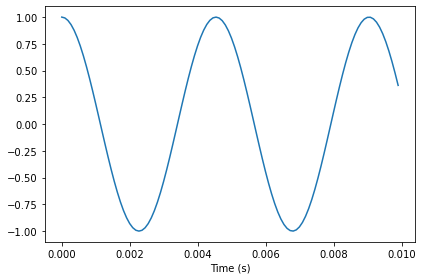

In [4]:
wave1.segment(start=0, duration=0.01).plot()
decorate(xlabel='Time (s)')

And near the end.

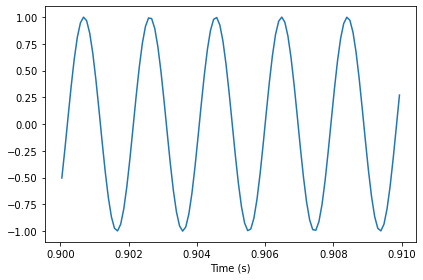

In [5]:
wave1.segment(start=0.9, duration=0.01).plot()
decorate(xlabel='Time (s)')

Here's an exponential chirp with the same frequency range and duration.

In [6]:
from thinkdsp import ExpoChirp

signal = ExpoChirp(start=220, end=880)
wave2 = signal.make_wave(duration=2)
wave2.make_audio()

## Leakage

Spectral leakage is when some of the energy at one frequency appears at another frequency (usually nearby).

Let's look at the effect of leakage on a sine signal (which only contains one frequency component).

In [7]:
from thinkdsp import SinSignal

signal = SinSignal(freq=440)

If the duration is an integer multiple of the period, the beginning and end of the segment line up, and we get minimal leakage.

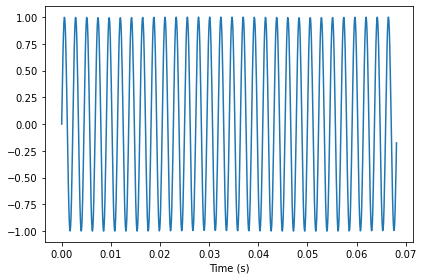

In [8]:
duration = signal.period * 30
wave = signal.make_wave(duration)
wave.plot()
decorate(xlabel='Time (s)')

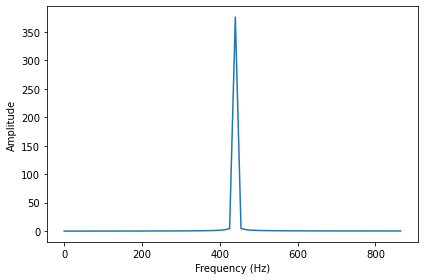

In [9]:
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

If the duration is not a multiple of a period, the leakage is pretty bad.

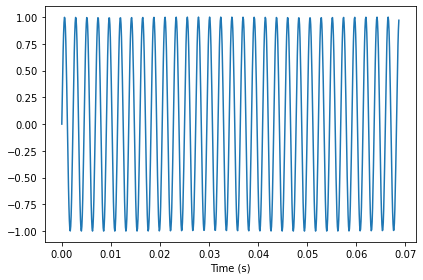

In [10]:
duration = signal.period * 30.25
wave = signal.make_wave(duration)
wave.plot()
decorate(xlabel='Time (s)')

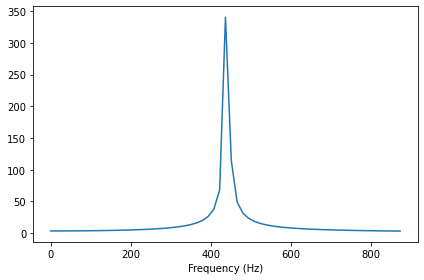

In [11]:
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)')

Windowing helps (but notice that it reduces the total energy).

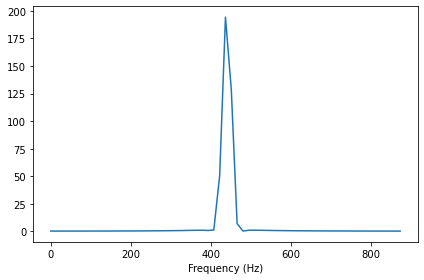

In [12]:
wave.hamming()
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)')

## Spectrogram

If you blindly compute the DFT of a non-periodic segment, you get "motion blur".

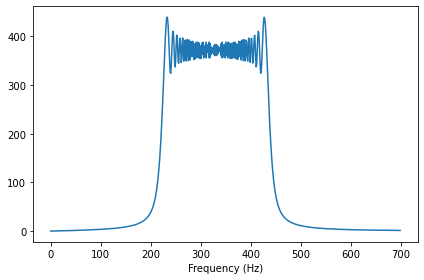

In [13]:
signal = Chirp(start=220, end=440)
wave = signal.make_wave(duration=1)
spectrum = wave.make_spectrum()
spectrum.plot(high=700)
decorate(xlabel='Frequency (Hz)')

A spectrogram is a visualization of a short-time DFT that lets you see how the spectrum varies over time.

In [14]:
def plot_spectrogram(wave, seg_length):
    """
    """
    spectrogram = wave.make_spectrogram(seg_length)
    print('Time resolution (s)', spectrogram.time_res)
    print('Frequency resolution (Hz)', spectrogram.freq_res)
    spectrogram.plot(high=700)
    decorate(xlabel='Time(s)', ylabel='Frequency (Hz)')

Time resolution (s) 0.046439909297052155
Frequency resolution (Hz) 21.533203125


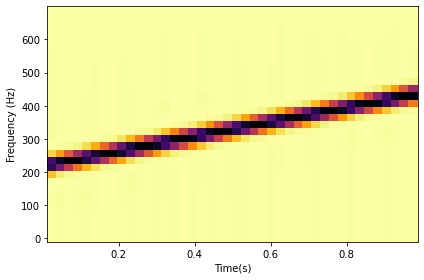

In [15]:
signal = Chirp(start=220, end=440)
wave = signal.make_wave(duration=1, framerate=11025)
plot_spectrogram(wave, 512)

If you increase the segment length, you get better frequency resolution, worse time resolution.

Time resolution (s) 0.09287981859410431
Frequency resolution (Hz) 10.7666015625


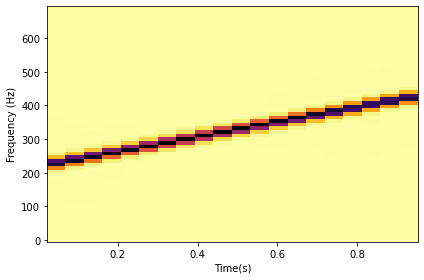

In [16]:
plot_spectrogram(wave, 1024)

If you decrease the segment length, you get better time resolution, worse frequency resolution.

Time resolution (s) 0.023219954648526078
Frequency resolution (Hz) 43.06640625


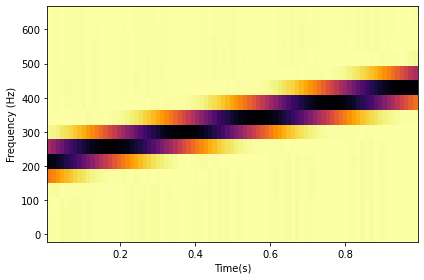

In [17]:
plot_spectrogram(wave, 256)

In [18]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.IntSlider(min=128, max=4096, value=100, step=128)
interact(plot_spectrogram, wave=fixed(wave), seg_length=slider);

interactive(children=(IntSlider(value=128, description='seg_length', max=4096, min=128, step=128), Output()), …

## Spectrum of a chirp

The following interaction lets you customize the Eye of Sauron as you vary the start and end frequency of the chirp.

In [19]:
def eye_of_sauron(start, end):
    """Plots the spectrum of a chirp.
    
    start: initial frequency
    end: final frequency
    """
    signal =  Chirp(start=start, end=end)
    wave = signal.make_wave(duration=0.5)
    spectrum = wave.make_spectrum()
    
    spectrum.plot(high=1200)
    decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

In [20]:
slider1 = widgets.FloatSlider(min=100, max=1000, value=100, step=50)
slider2 = widgets.FloatSlider(min=100, max=1000, value=200, step=50)
interact(eye_of_sauron, start=slider1, end=slider2);

interactive(children=(FloatSlider(value=100.0, description='start', max=1000.0, min=100.0, step=50.0), FloatSl…

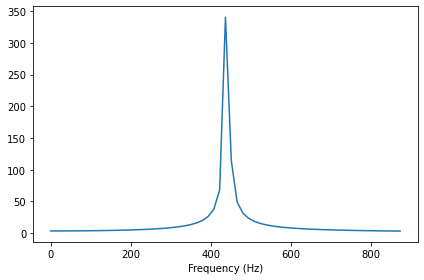

In [21]:
#ex1

signal = SinSignal(freq=440)
duration = signal.period * 30.25
wave = signal.make_wave(duration)
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
decorate(xlabel='Frequency (Hz)')

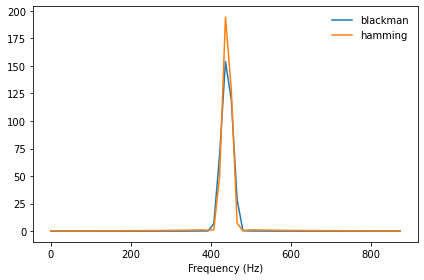

In [22]:
wave = signal.make_wave(duration)
wave.ys *= np.blackman(len(wave.ys))
spectrum = wave.make_spectrum()
spectrum.plot(high=880, label="blackman")

wave = signal.make_wave(duration)
wave.ys *= np.hamming(len(wave.ys))
spectrum = wave.make_spectrum()
spectrum.plot(high=880, label="hamming")

decorate(xlabel='Frequency (Hz)')

In [23]:
#ex2 

import thinkdsp
import numpy as np
import math

PI2 = 2 * math.pi

class SawtoothChirp(thinkdsp.Chirp):
    def evaluate(self, ts):
        freqs = np.linspace(self.start, self.end, len(ts))
        dts = np.diff(ts, prepend=0)
        dphis = PI2 * freqs * dts
        phases = np.cumsum(dphis)
        cycles = phases / PI2
        frac, _ = np.modf(cycles)
        ys = thinkdsp.normalize(thinkdsp.unbias(frac), self.amp)
        return ys
    
s = SawtoothChirp(start=1318, end=5274)
w = s.make_wave(duration=4, framerate=10000)
w.apodize()
w.make_audio()

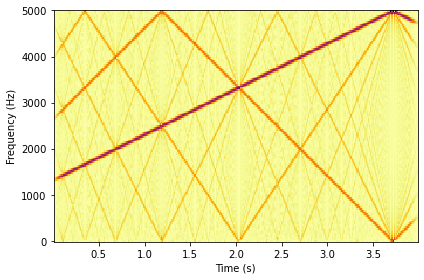

In [24]:
sp = w.make_spectrogram(256)
sp.plot()
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

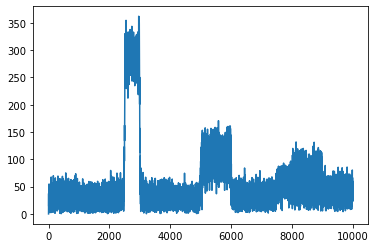

In [25]:
#ex3 

s = SawtoothChirp(start=2500, end=3000)
w = s.make_wave(duration=1, framerate=20000)
w.make_spectrum().plot()

In [26]:
#ex4

wave = thinkdsp.read_wave('gl.wav')
wave.make_audio()

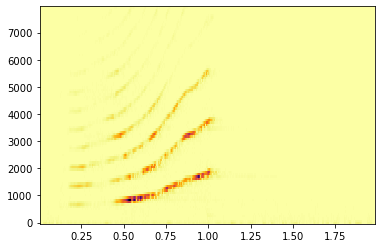

In [27]:
wave.make_spectrogram(512).plot(high=8000)

In [31]:
#ex5

class TromboneGliss(thinkdsp.Chirp):
    def evaluate(self, ts):
        l1, l2 = 1.0 / self.start, 1.0 / self.end
        lengths = np.linspace(l1, l2, len(ts))
        freqs = 1 / lengths
        
        dts = np.diff(ts, prepend=0)
        dphis = PI2 * freqs * dts
        phases = np.cumsum(dphis)
        ys = self.amp * np.cos(phases)
        return ys
s = TromboneGliss(262, 349)
w1 = s.make_wave(duration=1)
w1.make_audio()

In [32]:
sig = TromboneGliss(349, 262)
w2 = sig.make_wave(duration=1)
w2.make_audio()

In [33]:
w = w1 | w2
w.make_audio()

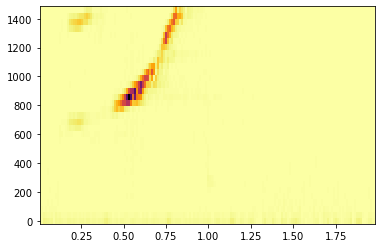

In [36]:
spec_gram = wave.make_spectrogram(1024)
spec_gram.plot(high=1500)

In [39]:
#ex6 

wave = thinkdsp.read_wave('vocals.wav')
wave.make_audio()

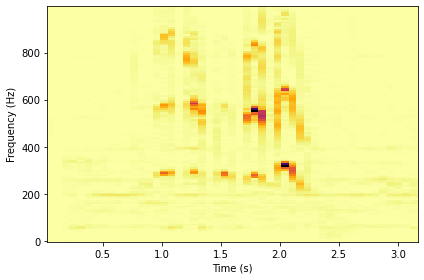

In [40]:
wave.make_spectrogram(1024).plot(high=1000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')